# Redis (Remote Dictionary Server)

## Persistencia
Los datos almacenados solo en la memoria de un programa en ejecución se llaman "volátiles", ya que desaparecen cuando el programa termina.
Los datos que siguen existiendo después de que el programa que los creó finaliza se denominan "persistentes". En general, los archivos almacenados en un sistema de archivos son persistentes, al igual que los datos almacenados en bases de datos.
Una forma sencilla de hacer que los datos sean persistentes es guardarlos en un archivo. Por ejemplo, antes de que el programa termine, podría convertir sus estructuras de datos a un formato como [JSON](https://en.wikipedia.org/wiki/JSON) y luego escribirlas en un archivo. Al iniciarse de nuevo, podría leer el archivo y reconstruir las estructuras de datos.

Pero existen varios problemas con esta solución:
1. Leer y escribir estructuras de datos grandes (como un Web index) sería lento.
2. Es posible que toda la estructura de datos no quepa en la memoria de un solo programa en ejecución.
3. Si un programa termina inesperadamente (por ejemplo, debido a un corte de energía), se perderían todos los cambios realizados desde la última vez que el programa se inició.
Una mejor alternativa es una base de datos que proporcione almacenamiento persistente y la capacidad de leer y escribir partes de la base de datos sin necesidad de leer y escribir todo el contenido.

Existen muchos tipos de [database management systems](https://en.wikipedia.org/wiki/Database) (DBMS) que ofrecen estas capacidades.
La base de datos que usaremos es Redis, la cual organiza los datos en estructuras similares a las de Python. Entre otras, ofrece listas, hashes (similares a los diccionarios de Python) y conjuntos.
Redis es una "base de datos de clave-valor", lo que significa que representa un mapeo de claves a valores. En Redis, las claves son cadenas de texto y los valores pueden ser de varios tipos.

In [ ]:
# Instalar el cliente de Redis
!pip install redis

Redis suele ejecutarse como un servicio remoto; de hecho, su nombre significa "Servidor de Diccionario Remoto" (REmote DIctionary Server). Para usar Redis, debes ejecutar el servidor Redis en algún lugar y luego conectarte a él mediante un cliente de Redis.

**Actividad**:
- Conectarse al Redis del `docker-compose`
- Confirmar que el ping responde `True`

In [ ]:
import redis

# Conexión a Redis local
#r = redis.Redis(host='localhost', port=6379, decode_responses=True)
r = redis.Redis(host='localhost', port=6379, decode_responses=True)
# Decodifica automáticamente las respuestas de Redis para que no devuelva siempre bytes.

# Probar la conexión
r.ping()

## Redis-py
Utilizaremos [Redis-py](https://Redis-py.readthedocs.io/en/stable/index.html).
como libreria para interactuar con python con Redis.

Metodo `set` para crear un par key-value en la base.

In [ ]:
r.set('key', 'value')

In [ ]:
print("ROL:", r.info("replication")["role"])

Metodo `get` para obtener el valor de una clave determinada.

In [ ]:
r.get('key')

In [ ]:
# Strings
r.set("nombre", "Juan")
print(r.get("nombre"))

# Listas
r.rpush("colores", "rojo", "azul", "verde")
print(r.lrange("colores", 0, -1))

r.lpush("colores2", "rojo", "azul", "verde")
print(r.lrange("colores2", 0, -1))

# Sets
r.sadd("etiquetas", "python", "redis", "backend", "redis")
print(r.smembers("etiquetas"))

# Hashes
r.hset("usuario:1001", mapping={"nombre": "Ana", "edad": 30})
print(r.hgetall("usuario:1001"))

📗 **Notebook 2: Tipos de datos básicos en Redis**
**Objetivos**:
- Usar strings, listas, sets y hashes

El resultado por default no es un string; es un [bytearray](https://stackoverflow.com/questions/6224052/what-is-the-difference-between-a-string-and-a-byte-string).
Un bytearray se comporta como un string en ocasiones, en nuestra configuración estamos forzando el decode en las respuestas para que no devuelva un bytearray.

Los valores tambien pueden ser integers o floating-point.

In [ ]:
r.set('x', '5') #5

Redis tiene algunas funciones numericas, como por ejemplo `incr`.

In [ ]:
r.incr('x')

Si queremos usarlo para calculos, habra que castearlo.

La funcion `mset` permite setar multiples pares clave-valor.

In [ ]:
d = dict(x=5, y='valor_y', z=1.24)
r.mset(d)

In [ ]:
r.get('y')

In [ ]:
r.get('z')

Existe el comando `mget` para obtener mas de un valor a la vez.

In [ ]:
r.mget('y','z')

## JSON
El modulo `json` provee la funcion `dumps`, que crea una representacion language-independent de algunos de los objetos Python.

In [ ]:
# Definición de JSON objet en python
import json
user_data = {
    "name": "Alice",
    "age": 30,
    "email": "alice@example.com",
    "preferences": ["reading", "traveling", "cooking"]
}
user_data = dict(name= "Alice", age= 30, email= "alice@example.com", preferences= ["reading", "traveling", "cooking"])
print(type(user_data))
# Conversion de user_data en JSON, con dump, y guardado en Redis.
r.set("user:1", json.dumps(user_data))
print(type(json.dumps(user_data)))
# Recuperacion del JSON desde Redis y conversion a un diccionacion de Python.
user_guardado = json.loads(r.get("user:1")) #pasa de string a dict si es que puede
print(user_guardado, 'tipo: ', type(user_guardado))
print(r.get("user:1"), 'tipo: ', type(r.get("user:1")))

#### Modificar y actualizar un valor JSON en Redis
Para actualizar un campo específico en un objeto JSON almacenado, puedes recuperarlo, modificar el diccionario en Python y luego almacenarlo de nuevo en Redis.
#### Modificar la edad de Alice, user:1, a 31 años.

In [ ]:
# Leer el JSON desde Redis
usuario_json = r.get("user:1") 
usuario_dict = json.loads(usuario_json) 

# Modificar el campo "activo"
usuario_dict["age"] = 31 

# Volver a guardar el JSON modificado
r.set("user:1", json.dumps(usuario_dict))

In [ ]:
# Verificar
print(json.loads(r.get("user:1")))

#### Eliminar el email

In [ ]:
# Leer el JSON desde Redis
usuario_json = r.get("user:1")
usuario_dict = json.loads(usuario_json)

# Eliminar el campo "email"
if "email" in usuario_dict: 
    del usuario_dict["email"] 

# Guardar el diccionario actualizado
r.set("user:1", json.dumps(usuario_dict))    

In [ ]:
# Verificar
print(json.loads(r.get("user:1")))

## Redis Data Types
JSON puede representar la mayoría de los objetos de Python, por lo que podríamos usarlo para almacenar estructuras de datos arbitrarias en Redis. Pero, en ese caso, Redis solo sabe que son cadenas de texto; no puede trabajar con ellas como estructuras de datos. Por ejemplo, si almacenamos una estructura de datos en JSON, la única forma de modificarla sería:
Obtener toda la estructura, que podría ser grande, cargarla de nuevo en una estructura de Python, modificar la estructura de Python, convertirla de nuevo a una cadena JSON, y reemplazar el valor antiguo en la base de datos con el nuevo valor.
Eso no es muy eficiente. Una mejor alternativa es usar los tipos de datos que Redis proporciona directamente, [Redis Data Types Intro](https://Redis.io/topics/data-types-intro).

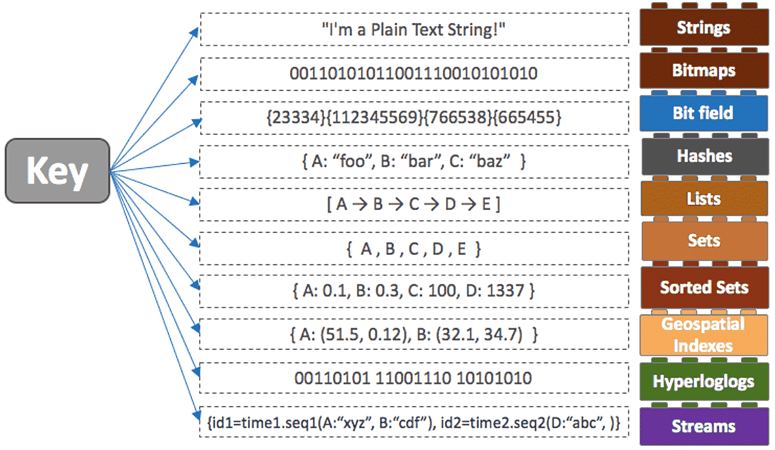

## 📌 Listas
En Redis, las listas son listas enlazadas de strings ordenados, y se pueden modificar tanto por la izquierda como por la derecha.
 El método `rpush` (existe `lpush` también) agrega nuevos elementos al final de una lista (la r indica el lado derecho de la lista).

In [ ]:
# Crea lista_1 con los elementos [1, 2, 3]
r.rpush('lista_1', 1, 2, 3)

In [ ]:
# Mostrar todos los elementos de una lista
r.lrange("lista_1", 0, -1)

In [ ]:
# llen retorna la longitud de la lista.
r.llen('lista_1') 

In [ ]:
# lrange  devuelve un rango de elementos de una lista.
r.lrange('lista_1', 0, 0) #inclusive a inclusive

In [ ]:
# rpop remueve elementos del fin de la lista (existe lpop para quitar el primer elemento de la lista).
r.rpop('lista_1')

Uso de `lpush` y `lpop` para obtener datos de una lista en Redis.

In [ ]:
r.lpush('lista_1', -3, -2, -1)

In [ ]:
r.lpop('lista_1')

## 📌 Hash
Un [Redis hash](https://Redis.io/commands#hash) es similar a un diccionario en Python, pero con una nomenclatura es un poco diferente.
Lo que llamaríamos "key" en un diccionario de Python, se llama "field" en un hash de Redis.
Un hash en Redis es una estructura de datos que almacena pares campo–valor, como un diccionario en Python. Es ideal para representar objetos con atributos, como un usuario, producto, configuración, etc.

In [ ]:
#El método hset establece un par campo-valor en un hash
r.hset('hash_1', 'field', 'value')

In [ ]:
# hget busca un campo y retorna su valor.
r.hget('hash_1', 'field')

**`hset`** podria tomar un JSON de python como entrada

In [ ]:
d = dict(a=1, b=2, c=3)
r.hset('h', mapping=d)

**`hscan_iter`** se puede utilizar para iterar los elementos de un hash.

In [ ]:
for field, value in r.hscan_iter('h'):
    print(field, value)

#### Almacenar múltiples objetos JSON en Redis usando un hash
#### Redis también permite almacenar varios campos en una estructura de tipo hash. Esto es útil si queremos almacenar múltiples valores relacionados con una sola clave.

In [ ]:
# Json objects
user1 = {"name": "Alice", "age": 30}
user2 = {"name": "Bob", "age": 25}

# Se guarda cada JSON dentro de un Redis Hash
r.hset("users", "user:1001", json.dumps(user1))
r.hset("users", "user:1002", json.dumps(user2))

# Recuperar y decode la informacion del JSON
retrieved_user1 = json.loads(r.hget("users", "user:1001"))
retrieved_user2 = json.loads(r.hget("users", "user:1002"))

print("Usuario 1:", retrieved_user1)
print("Usuario 2:", retrieved_user2)

In [ ]:
# Crear un usuario como hash
r.hset("user:2", mapping={
    "nombre": "Ana",
    "email": "ana@example.com",
    "edad": "35",
    "ciudad": "Buenos Aires",
    "activo": "True"
})


# Obtener un campo específico
print(r.hget("user:2", "email"))

# Obtener todos los campos y valores
print(r.hgetall("user:2"))

# Obtener solo las claves (nombres de campos)
print(r.hkeys("user:2"))

# Obtener solo los valores
print(r.hvals("user:2"))

## 📌 TTL: Time to Live
Es un mecanismo que define un tiempo de expiración para una clave específica. Esto permite que los datos sean eliminados automáticamente después de un cierto periodo, lo que es útil para manejar datos temporales o de caché.

In [ ]:
# Guardar un valor con TTL de 60 segundos
r.set("clave_temporal", "valor", ex=60)
print(r.get("clave_temporal"))

In [ ]:
# Consultar el tiempo de vida para un clave (-2 cuando no tiene TTL)
ttl = r.ttl("clave_temporal")
print("Tiempo restante:", ttl, "segundos")

In [ ]:
print(r.get("clave_temporal"))

In [ ]:
# Renovar el TTL de la clave a 30 segundos
r.expire("clave_temporal", 30)

# Mostrar el nuevo TTL para confirmar
new_ttl = r.ttl("clave_temporal")
print(f"Nuevo TTL de 'clave_temporal': {new_ttl} segundos")

In [ ]:
# persist elimina el TTL de una clave y la hace persistente (TTL = -1)
r.persist("clave_temporal")
print(r.ttl("clave_temporal"))

### HASH vs LIST

In [ ]:
import time


N = 1_0_000

# Limpio las claves para empezar limpio
r.delete("mi_hash")
r.delete("mi_lista")

# --- Medir escritura en HASH ---
start_hash_write = time.time()
for i in range(N):
    r.hset("mi_hash", f"campo_{i}", f"valor_{i}")
end_hash_write = time.time()

# --- Medir lectura en HASH ---
start_hash_read = time.time()
for i in range(N):
    _ = r.hget("mi_hash", f"campo_{i}")
end_hash_read = time.time()

# --- Medir escritura en LIST ---
start_list_write = time.time()
for i in range(N):
    r.rpush("mi_lista", f"valor_{i}")
end_list_write = time.time()

# --- Medir lectura en LIST ---
start_list_read = time.time()
# Para listas, uso lindex para acceder por índice LINDEX
for i in range(N):
    _ = r.lindex("mi_lista", i)
end_list_read = time.time()

print(f"Hash escritura: {end_hash_write - start_hash_write:.4f} segundos")
print(f"Hash lectura:   {end_hash_read - start_hash_read:.4f} segundos")
print(f"Lista escritura:{end_list_write - start_list_write:.4f} segundos")
print(f"Lista lectura:  {end_list_read - start_list_read:.4f} segundos")

## Entendimiento
Hash escritura: poner 100k pares campo-valor en un hash.    
Hash lectura: obtener 100k campos distintos del hash.   
Lista escritura: insertar 100k elementos al final de la lista.  
Lista lectura: leer 100k elementos por índice con lindex.   

## Guia 6

### Ejercicio 1 
Listas: Simular una lista de tareas pendientes.

a) Agregar tareas a una lista en Redis.

b) Recuperar todas las tareas de la lista.

c) Eliminar tareas de la lista.

d) Obtener la primera y última tarea de la lista.

In [ ]:
tareas = [
    # Estudio
    "Repasar el tema de probabilidad continua",
    "Resolver los ejercicios 1 al 10 del capítulo 5",
    "Leer el capítulo 3 de A Court of Thorns and Roses",
    "Preparar resumen para la clase de matemáticas",

    # Trabajo / Tecnología
    "Revisar el script de carga de datos en PostgreSQL",
    "Crear columna de embeddings en el DataFrame",
    "Hacer backup del esquema crudo",
    "Practicar consultas SQL con joins y subqueries",

    # Tiempo libre
    "Practicar una canción de Ed Sheeran en el piano",
    "Tejer una bufanda nueva con lana gris",
    "Ver una película de terror (Hereditary o Suspiria)",
    "Leer un cuento corto de Stephen King",

    # Casa
    "Hacer las compras del supermercado",
    "Cocinar tortilla de papas o pizza con cebolla",
    "Lavar la ropa y ordenar el cuarto"
]

#a)
for tarea in tareas:
    r.rpush("tareas", tarea)
    

In [ ]:
#b)
r.lrange("tareas", 0, -1)

In [ ]:
#c)
r.rpop("tareas", 2)
r.lpop("tareas")

In [ ]:
#d)
print(r.lrange("tareas", 0, 0))
print(r.lrange("tareas", -1, -1))

### Ejercicio 2
Hash: Gestionar de información de empleado.

a) Almacenar la información de un empleado (nombre, puesto y salario) usando un hash.

b) Obtener la información de ese empleado.

c) Actualizar uno de los campos (por ejemplo, el salario).

d) Eliminar uno de los campos (por ejemplo, el puesto).

In [ ]:
datos = {"nombre":"Azul", "apellido":"Barr", "edad":23, "puesto":"desarrollo", "salario": "1B"}
datos = dict(nombre="Azul", apellido="Barr", edad=23, puesto="desarrollo", salario= "1B")
#a)
r.hset('empleado2', mapping=datos)
r.hset('empleado3', 'datos', json.dumps(datos))

In [ ]:
#b)
r.hgetall('empleado2')

In [ ]:
#c)
r.hset('empleado2', 'salario', "0")


In [ ]:
#d)
r.hdel('empleado2', 'salario')

### Ejercicio 3
JSON: Gestión de datos de reserva aerea.

a) Crear un diccionario con datos de una reserva aerea (aeropuerto de salida, llegada, fecha, asiento,
 precio, preferencias de comida).

b) Usar ‘json’ para crear una respresentacion en string del diccionario.

c) Guardarlo como valor en Redis.

d) Recuperar dicho valor y volver a convertirlo en un diccionario.

e) Imprimir el diccionario por consola.

In [ ]:
import json
#a)
datos = dict(aer_salida='Ezeiza', ear_llegada='Aeroparque', fecha='2025-11-10', asiento='2B', precio=9000, preferencias_comida=None)
#b)
datos_json = json.dumps(datos)
#c)
r.set('reserva', datos_json)


In [ ]:
#d)
valor_dict = json.loads(r.get('reserva'))
#e)
print(valor_dict)

### Ejercicio 4
TTL:

a) Crear una clave con un TTL de 45 segundos.

b) Imprimir un mensaje por pantalla, print, cuando le queden 10 segundos de vida.

c) Imprimir un mensaje por pantalla, print, cuando la clave haya expirado.

In [ ]:
#a)
r.set('clave_con_ex', 'valor', ex=45)

In [ ]:
#b)
if r.ttl('clave_con_ex') > 10:
    while (r.ttl('clave_con_ex') > 10):
        pass
    print('le quedan 10 segundos de vida: ', r.ttl('clave_con_ex'))
#c)
while r.ttl('clave_con_ex') > 0:
    pass
print('la clave expiró: ', r.ttl('clave_con_ex'))


## Borrado
Con este ciclo, puede borrar todos los elementos de la instancia de Redis que estamos utilizando.

In [180]:
# Solo para ambiente local
for key in r.keys():
    r.delete(key)